In [206]:
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import numpy as np
import json 
import pandas as pd
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader, Data
import warnings
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.0.1+cu117
11.7
cuda


In [207]:
filename_graphs = 'datasets/reddit_threads/reddit_edges.json'
filename_targets = 'datasets/reddit_threads/reddit_target.csv'

labels = pd.read_csv(filename_targets)
# Load the data
with open(filename_graphs, 'r') as f:
    graphs = json.load(f)

num_sample = 10000
labels = labels[:num_sample]
print(labels.shape)
graphs = {k: graphs[str(k)] for k in labels['id'][:num_sample]}



(10000, 2)


In [208]:
data_list = []
y = labels['target'].values
num_features = 4

for idx, edge_list in graphs.items():
    edge_index = torch.tensor(edge_list, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = edge_index.view(2, -1)
    num_nodes = edge_index.max().item() + 1
    label = torch.tensor(y[int(idx)])
    x = torch.randn(num_nodes, num_features)
    data = Data(edge_index=edge_index, y=label, x=x)
    data_list.append(data)



In [202]:
print(data_list[12].edge_index)
print(data_list[12].edge_index.shape)
print(data_list[12].y)
print(data_list[12].x)



tensor([[ 0,  1,  1,  2,  2,  3,  4,  5,  6,  6,  7,  8,  8,  8,  8,  8,  8,  8,
          8,  8, 10, 11],
        [ 8,  8, 11,  8, 10,  8,  8,  8,  8, 17,  8,  8,  9, 11, 12, 13, 14, 15,
         16, 17, 12, 17]])
torch.Size([2, 22])
tensor(1)
tensor([[ 0.1371, -0.8210, -0.8375, -0.8062],
        [ 0.9387, -0.7594, -0.2586,  0.1733],
        [ 0.1962, -0.0685, -0.2488, -0.8317],
        [ 0.0690,  1.4408, -0.2105, -2.6052],
        [ 1.3682,  0.5251, -1.1285, -0.3205],
        [ 1.9814,  0.6834,  0.7238,  0.1657],
        [-0.3468, -0.1165,  0.3193,  0.1273],
        [ 0.5275, -2.5989, -0.4057, -0.3580],
        [ 0.6417,  0.1690, -0.0095,  2.0343],
        [ 1.1316, -0.9186,  0.4531, -1.1772],
        [ 0.6416, -1.0149,  0.5335, -1.9527],
        [ 0.7418,  1.0817,  0.3561,  1.3526],
        [ 0.2587, -1.2384, -0.1561, -0.9033],
        [-0.7113, -1.2031,  1.2345, -1.1545],
        [ 1.1072, -0.6395, -0.6692,  0.2562],
        [ 0.4633,  0.8874,  0.0954,  0.3002],
        [ 0.1159,  

In [216]:

embedding_size = 64

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)

        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)

        self.fc1 = nn.Linear(embedding_size*2, 64)
        self.fc2 = nn.Linear(64, 128)
        self.out = nn.Linear(128, 2)
    
    def forward(self, x, edge_index, batch_index):
        x = self.initial_conv(x, edge_index)
        x = F.relu(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.out(x)

        return out, x




GNN(
  (initial_conv): GCNConv(4, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
epoch:  0 loss:  0.6886781454086304
epoch:  100 loss:  0.3858588933944702
epoch:  200 loss:  0.30677005648612976
epoch:  300 loss:  0.4185739755630493


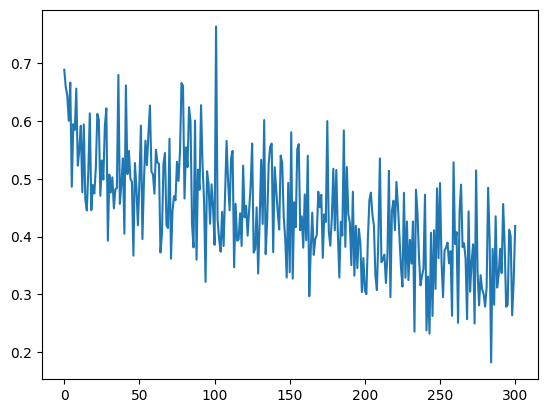

In [220]:
warnings.filterwarnings('ignore')
model = GNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

data_size = len(data_list)
batch_size = 50

train_loader = DataLoader(data_list[:int(data_size*0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_list[int(data_size*0.8):], batch_size=batch_size, shuffle=True)
epochs = 300
loss_over_time = []

for epoch in range(epochs+1):
    for batch in train_loader:
        batch.to(device)
        model.zero_grad()
        pred, embedding = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print('epoch: ', epoch, 'loss: ', loss.item())
    loss_over_time.append(loss.item())

plt.plot(loss_over_time)
    

In [221]:
with torch.no_grad():
  correct = 0
  total = 0
  for data in test_loader:
    data.to(device)
    outputs, embeddings = model(data.x, data.edge_index, data.batch)
    for i in range(len(outputs)):
      pred = torch.argmax(outputs[i])
      if pred == data.y[i]:
        correct += 1
      total += 1

  print(f'Accuracy: {round(correct/total, 3)}')

Accuracy: 0.699
